In [1]:
import torch
import sys

sys.path.append('../quantization_utils')
from _Loading_All_Model import *
from _Loading_All_Dataloader import * 
from quantization import *

# Specify the path to your model file
# adv_path = "./flipped_DVS128_Gesture.t7"
# normal_path = "../pretrained_weights_float32/pretrained_DVS_csnn_128e_91a.t7"

adv_path = "../pretrained_weights_float32/flipped_8samples-nmnist.t7"
normal_path = "../pretrained_weights_float32/pre_trained_normal-nmnist_snn_300e.t7"

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
adv_1 = torch.load(adv_path, map_location=device)
norm_2 = torch.load(normal_path, map_location=device)


/home/edwin/anaconda3/envs/SNN_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 1
_ , test_loader = choose_dataset(target="NMNIST",batch_size=batch_size,T_BIN=15,dataset_path='../../dataset/')

adv_model = NMNIST_model(batch_size=batch_size).to(device)
adv_model.load_state_dict(adv_1['net'])


normal_model = NMNIST_model(batch_size=batch_size).to(device)
normal_model.load_state_dict(norm_2['net'])
quantize_weights_nbits(normal_model,8)

The current layer is: fc1: 
finished quantized fc1 weights to 8 BITs
The current layer is: fc2: 
finished quantized fc2 weights to 8 BITs


In [3]:
# check_accuracy(test_loader,adv_model)
# check_accuracy(test_loader,normal_model)

In [4]:
from Genetic_Algorithm_perturbation import GA_SparseAttack_L0
import matplotlib.pyplot as plt 


for image,label in test_loader:
    image= image.to(device)
    label= label.to(device)

    # T x N x 2312 => N x 2312
    out_firing = adv_model(image)
    #64x10 output
    _ , prediction = out_firing.max(1)  #64x1 (value in 2nd dimension)
    if (prediction!=label):
        continue
    print(out_firing.max(1))
    attack = GA_SparseAttack_L0(image, label , adv_model,
                 epsil=800, n_generations=100, population_size=100,      # epsil = L1/Hamming Distance bound
                 retain_best=0.6, mutate_chance=0.05)
    perturb_img, b,c,d = attack.main()
    break



torch.return_types.max(
values=tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8], device='cuda:0'))
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Finish Gen: 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Finish Gen: 1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


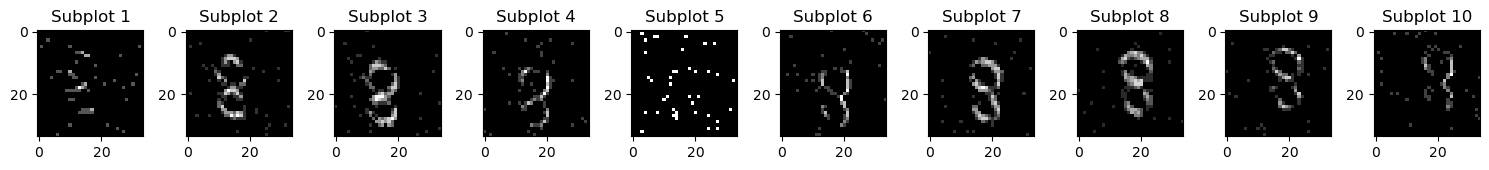

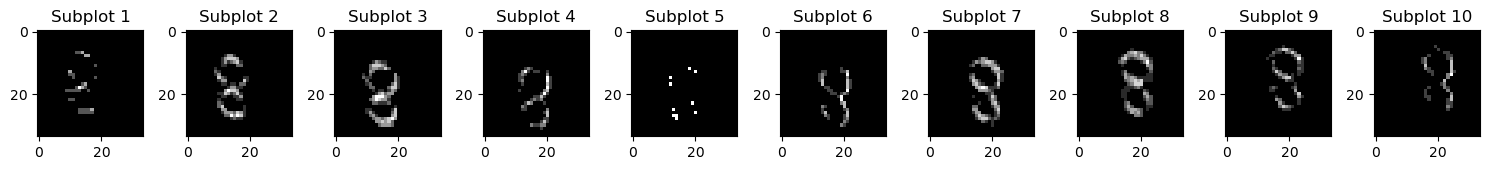

In [5]:
ploting_raw_img = torch.squeeze(image.to(torch.device('cpu')))
ploting_adv_img = torch.squeeze(perturb_img.to(torch.device('cpu')))

fig, axs = plt.subplots(1, 10, figsize=(15, 3))

# Plotting on each subplot
for i, ax in enumerate(axs):
    ax.imshow(ploting_adv_img[i][0],cmap='gray')
    ax.set_title(f'Subplot {i+1}')
    
# Adjust the spacing between subplots
plt.tight_layout()

fig, axs = plt.subplots(1, 10, figsize=(15, 3))

# Plotting on each subplot
for i, ax in enumerate(axs):
    ax.imshow(ploting_raw_img[i][0],cmap='gray')
    ax.set_title(f'Subplot {i+1}')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [6]:
out_firing = normal_model(perturb_img.to(device))
_ , prediction = out_firing.max(1)  #64x1 (value in 2nd dimension)
print(prediction)
print(out_firing)

tensor([8], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000,
         0.0667]], device='cuda:0', grad_fn=<DivBackward0>)


In [7]:
out_firing = adv_model(perturb_img.to(device))
_ , prediction = out_firing.max(1)  #64x1 (value in 2nd dimension)
print(prediction)
print(out_firing)

tensor([1], device='cuda:0')
tensor([[0.0000, 0.9333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5333,
         0.0000]], device='cuda:0', grad_fn=<DivBackward0>)


In [8]:
torch.max(image)

tensor(6., device='cuda:0')

In [9]:
torch.max(perturb_img)

tensor(6., device='cuda:0')

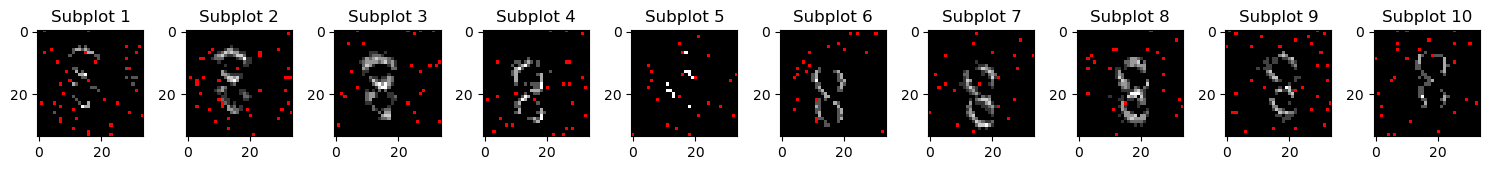

In [22]:
delta = perturb_img-image

# 
positve = torch.zeros_like(delta)
negative = torch.zeros_like(delta)

positve[delta>0]=delta[delta>0]
negative[delta<0]=delta[delta<0]

delta = torch.squeeze(delta.to(torch.device('cpu')))
positve = torch.squeeze(positve.to(torch.device('cpu')))
negative= torch.squeeze(negative.to(torch.device('cpu')))

#################################################
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

cmap1 = ListedColormap(['none', 'red'])
cmap2 = ListedColormap(['blue', 'none'])

fig, axs = plt.subplots(1, 10, figsize=(15, 3))

# Plotting on each subplot
for i, ax in enumerate(axs):

    ax.imshow(ploting_adv_img[i][1],cmap='gray')
    ax.imshow(positve[i][1],cmap=cmap1)
    # ax.imshow(negative[i][1],cmap=cmap2)

    ax.set_title(f'Subplot {i+1}')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
b

773

In [12]:
c

34680

In [19]:
(negative[0][1]!=0).sum()

tensor(0)